# Latent Representation with Autoencoders

- $M$ denotes the number of documents
- $N$ is number of words in a given document (document $i$ has $N_i$ words)
- $\alpha$ is the parameter of the Dirichlet prior on the per-document topic distributions
- $\beta$ is the parameter of the Dirichlet prior on the per-topic word distribution
- $\theta_i$ is the topic distribution for document $i$
- $\varphi_k$ is the word distribution for topic $k$
- $z_{ij}$ is the topic for the $j$-th word in document $i$
- $w_{ij}$ is the specific word.

## Data

In [1]:
import numpy as np
import random
from scipy.stats import dirichlet, multinomial
from scipy.sparse import lil_matrix
import pandas as pd
from sklearn.feature_extraction.text import TfidfTransformer

np.random.seed(37)
random.seed(37)

# number of topics
K = 10
# number of words
N = 500
# number of documents
M = 1_000

# priors on K topics
a = np.array([0.1, 0.2, 0.3, 0.4, 0.025, 0.015, 0.37, 0.88, 0.03, 0.08])
# priors on N words
b = np.full((1, N), 1 / N, dtype=float)[0]

# distribution of words in topic k
phi = [np.abs(dirichlet.rvs(b)[0]) + 0.0001 for _ in range(K)]
phi = [p / p.sum() for p in phi]
phi = np.array(phi)

# distribution of topics in document d
theta = [np.abs(dirichlet.rvs(a)[0]) + 0.0001 for _ in range(M)]
theta = [t / t.sum() for t in theta]
theta = np.array(theta)

# simulate the documents
texts = []
docs = []

# for each document
for i in range(M):
    d = {}
    t = []

    # for each word
    for j in range(N):
        # sample the possible topics
        z_ij = multinomial.rvs(1, theta[i])
        # get the identity of the topic; the one with the highest probability
        topic = np.argmax(z_ij)

        # sample the possible words from the topic
        w_ij = multinomial.rvs(1, phi[topic])
        # get the identity of the word; the one with the highest probability
        word = np.argmax(w_ij)

        if word not in d:
            d[word] = 0
        d[word] = d[word] + 1
        t.append('w{}'.format(word))
    docs.append(d)
    texts.append(' '.join(t))

# make a nice matrix
# C is a matrix of word counts (rows are documents, columns are words, elements are count values)
C = lil_matrix((M, N), dtype=np.int16)
for i, d in enumerate(docs):
    counts = sorted(list(d.items()), key=lambda tup: tup[0])
    for tup in counts:
        C[i, tup[0]] = tup[1]

# X is a matrix of tf-idf (rows are documents, columns are words, elements are tf-idf values)
X = TfidfTransformer().fit_transform(C).todense()
X.shape

(1000, 500)

## Dataset, Data Loader

In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import *

class DocDataset(Dataset):
    def __init__(self, X, device, clazz=0):
        self.__device = device
        self.__clazz = clazz
        self.__X = X

    def __len__(self):
        return self.__X.shape[0]

    def __getitem__(self, idx):
        item = torch.from_numpy(self.__X[idx,:])
        
        return item, self.__clazz

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

dataset = DocDataset(X=X, device=device)
data_loader = DataLoader(dataset, batch_size=64, shuffle=True, num_workers=1)

cuda


## Autoencoder

In [3]:
from torchvision import datasets
from torchvision import transforms

class AE(torch.nn.Module):
    def __init__(self, input_size):
        super().__init__()
        
        self.input_size = input_size
        self.drop_out = torch.nn.Dropout(p=0.5)
          
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(input_size, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 36),
            torch.nn.ReLU(),
            torch.nn.Linear(36, 18),
            torch.nn.ReLU(),
            torch.nn.Linear(18, 9)
        )
          
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(9, 18),
            torch.nn.ReLU(),
            torch.nn.Linear(18, 36),
            torch.nn.ReLU(),
            torch.nn.Linear(36, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, input_size)
        )
  
    def forward(self, x):
        drop_out = self.drop_out(x)
        encoded = self.encoder(drop_out)
        decoded = self.decoder(encoded)
        return decoded

## Learning

In [4]:
model = AE(input_size=X.shape[1]).double().to(device)
loss_function = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), momentum=0.99, lr=0.01, nesterov=True) 

epochs = 20
loss_df = []

for epoch in range(epochs):
    losses = []
    
    for (items, _) in data_loader:  
        items = items.to(device)
        optimizer.zero_grad()
        
        reconstructed = model(items)
        loss = loss_function(reconstructed, items)
        
        loss.backward()
        
        optimizer.step()
        
        losses.append(loss.detach().cpu().numpy().item())
    
    losses = np.array(losses)
    
    loss_df.append({
        'epoch': epoch + 1,
        'loss': losses.mean()
    })
    
loss_df = pd.DataFrame(loss_df)
loss_df.index = loss_df['epoch']
loss_df = loss_df.drop(columns=['epoch'])

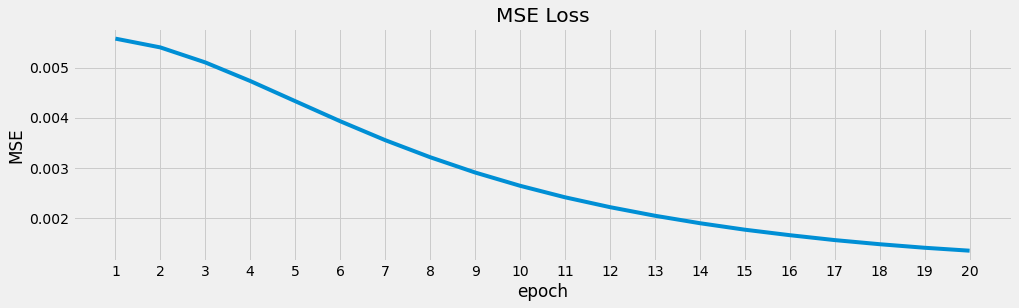

In [5]:
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')

ax = loss_df['loss'].plot(kind='line', figsize=(15, 4), title='MSE Loss', ylabel='MSE')
_ = ax.set_xticks(list(range(1, 21, 1)))

## Embedding

In [6]:
E = np.array([model.encoder(torch.from_numpy(X[r,:]).to(device)).cpu().detach().numpy()[0] 
              for r in range(X.shape[0])])
E.shape    

(1000, 9)

## Similarities

In [7]:
from sklearn.metrics.pairwise import cosine_similarity

d_sim = cosine_similarity(X, X)[np.triu_indices(X.shape[0], k=1)]
d_sim.shape

(499500,)

In [8]:
e_sim = cosine_similarity(E, E)[np.triu_indices(E.shape[0], k=1)]
e_sim.shape

(499500,)

In [9]:
from scipy.stats import kendalltau

kendalltau(d_sim, e_sim)

KendalltauResult(correlation=0.3703700793815839, pvalue=0.0)

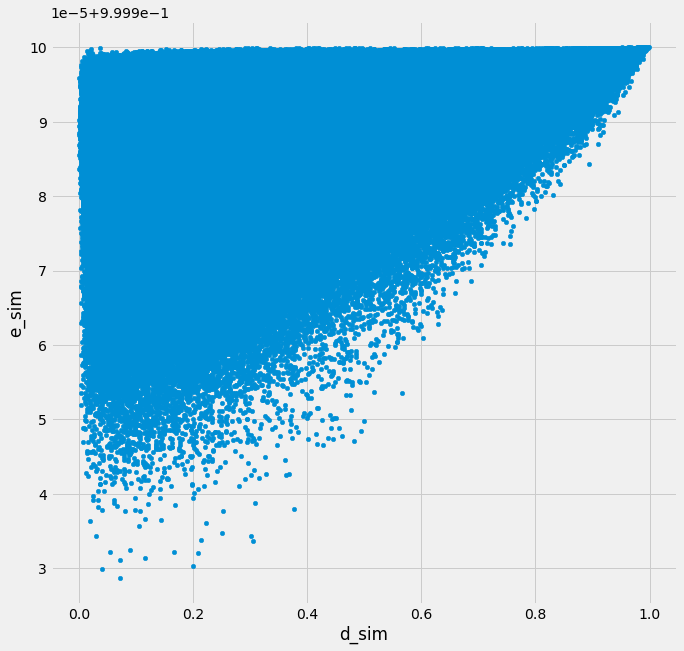

In [10]:
fig, ax = plt.subplots(figsize=(10, 10))

_ = pd.DataFrame({'d_sim': d_sim, 'e_sim': e_sim}).plot(kind='scatter', x='d_sim', y='e_sim', ax=ax)